# SOCCOM BGC Float visual assessment of data

In [1]:
import os                                              # to open folders
import glob                                            # to open folders
import numpy  as np
import xarray as xr
import pandas as pd
from   tqdm.notebook         import tqdm_notebook      # for progress bar in loops

# for plotting:
from   datetime              import date               # for saving figures with today's date
import matplotlib
import matplotlib.pyplot     as plt
import cmocean.cm            as cmo

# for map
import cartopy                                         # to make map
import cartopy.crs           as ccrs                   # for map projection
import cartopy.feature       as cfeature               # to add land features to map
import matplotlib.path       as mpath                  # to draw circle for map
import matplotlib.patches    as mpatches               # to draw boxes on map  

# Open dataset

In [82]:
base_directory = '/Users/hannah/Documents/UW-PMEL/Research/SO_BGC_clusters_repo/data/'

directory_with_data             = os.path.join(base_directory, '01_raw/SOCCOM_BGC_Argo_float_data/SOCCOM_LoResQC_LIAR_19May2022_netcdf/')
directory_for_intermediate_data = os.path.join(base_directory, '02_intermediate/SOCCOM_BGC_Argo_float_data/SOCCOM_LoResQC_LIAR_19May2022_netcdf/')
directory_for_processed_data    = os.path.join(base_directory, '03_processed/SOCCOM_BGC_Argo_float_data/')
combined_nc_file_name = 'SOCCOM_LoResQC_LIAR_19May2022_combined.nc'
combined_nc_file_name_SO_only  = 'SOCCOM_LoResQC_LIAR_19May2022_combined_SO_only.nc'

datasets_all = xr.open_dataset(os.path.join(base_directory, directory_for_processed_data, combined_nc_file_name))
datasets_SO  = xr.open_dataset(os.path.join(base_directory, directory_for_processed_data, combined_nc_file_name_SO_only))
datasets_SO

<xarray.Dataset>
Dimensions:      (profile: 24521, pressure: 321)
Coordinates:
  * pressure     (pressure) int64 0 5 10 15 20 25 ... 1580 1585 1590 1595 1600
Dimensions without coordinates: profile
Data variables: (12/22)
    floatnum     (profile) object ...
    latitude     (profile) float64 ...
    longitude    (profile) float64 ...
    juld         (profile) datetime64[ns] ...
    year         (profile) float64 ...
    month        (profile) float64 ...
    ...           ...
    sigma_theta  (profile, pressure) float64 ...
    b_bp700      (profile, pressure) float64 ...
    b_bp532      (profile, pressure) float64 ...
    b_bp_corr    (profile, pressure) float64 ...
    poc          (profile, pressure) float64 ...
    cdom         (profile, pressure) float64 ...

# Contour plot of selected floats to check data interpolation

In [211]:
def plot_contours_and_float_track(    
    dataset         : xr.core.dataset.Dataset,
    # variables_list  : lst,
    variable        : str,
    floatnum        : str,
    pressure_level  : int,
) -> None:
    """
    Plot the data to see what is in the dataset
        Args:
        dataset        (xr.core.dataset.Dataset): The dataset to plot
        variables_list (list of str)            : The variables in the dataset to plot
        floatnum       (str)                    : Number of the float to plot
    """
    
    from xhistogram.xarray import histogram
    
    # Check that variables are in the dataset:
    # for variable in variables_list:
    if variable not in ['temperature', 'salinity', 'pco2', 'dic', 'talk', 'pH', 'oxygen', 'nitrate', 'chl', 'sigma_theta', 'b_bp700', 'b_bp532', 'poc', 'cdom']:
        raise ValueError('Variable ' + variable + ' not in accepted list of variables: temperature, salinity, pco2, dic, talk, pH, oxygen, nitrate, chl, sigma_theta, b_bp700, b_bp532, poc, cdom')
    
    # Check that floatnum is in the dataset:
    if floatnum not in dataset.floatnum:
        raise ValueError('Float number ' + floatnum + ' not in dataset')
    
    
    
    ### SET VARIABLE PLOTTING PARAMETERS:
    
    if variable == 'temperature': 
        # colormap = cmo.thermal
        # colormap = plt.get_cmap(cmo.thermal,30)
        colormap = cmo.thermal._resample(30)
        cbar_label = 'Temperature ($^\circ$C)'
        plot_title = 'Temperature'
        
    if variable == 'salinity': 
        colormap = cmo.haline
        cbar_label = 'Salinity (pss)'
        plot_title = 'Salinity'
        
    if variable == 'pco2': 
        colormap = cmo.dense
        cbar_label = '$p$CO$_2$ ($\mu$atm)'
        plot_title = '$p$CO$_2$'
        
    if variable == 'dic': 
        colormap = cmo.matter
        cbar_label = 'DIC ($\mu$mol kg$^{-1}$)'
        plot_title = 'DIC'
        
    if variable == 'talk': 
        colormap = cmo.turbid
        cbar_label = 'Total Alkalinity ($\mu$mol kg$^{-1}$)'
        plot_title = 'Total Alkalinity'
        
    if variable == 'pH': 
        colormap = cmo.tempo
        cbar_label = 'pH'
        plot_title = 'pH'
        
    if variable == 'oxygen': 
        colormap = cmo.oxy
        cbar_label = 'Oxygen ($\mu$mol kg$^{-1}$)'
        plot_title = 'Oxygen'
        
    if variable == 'nitrate': 
        colormap = cmo.amp
        cbar_label = 'Nitrate ($\mu$mol kg$^{-1}$)'    
        plot_title = 'Nitrate'
                
    if variable == 'chl': 
        colormap = cmo.algae
        cbar_label = 'Chlorophyll (mg m$^{-3}$)'
        plot_title = 'Chlorophyll'
        
    if variable == 'sigma_theta': 
        colormap = cmo.dense
        cbar_label = 'Potential denisty at sea surface (kg m$^{-3}$)'
        plot_title = 'Potential denisty at sea surface'
        
    if variable == 'b_bp700': 
        colormap = cmo.rain
        cbar_label = 'Backscatter, 700 nm (m$^{-1}$)'
        plot_title = 'Backscatter, 700 nm'
        
    if variable == 'b_bp532': 
        colormap = cmo.rain
        cbar_label = 'Backscatter, 532 nm (m$^{-1}$)'
        plot_title = 'Backscatter, 532 nm'
        
    if variable == 'poc': 
        colormap = cmo.matter
        cbar_label = 'POC (mmol m$^{-3}$)'
        plot_title = 'POC'

    if variable == 'cdom': 
        colormap = cmo.matter
        cbar_label = 'CDOM ($^\circ$C)'
        plot_title = 'CDOM'
    

    ##############################
    ########## Set up ############
    ##############################

    ###### SAVE NAME ######
    savedate = date.today().strftime('%Y%m%d')
    savepath = '/Users/hannah/Documents/UW-PMEL/Research/SO_BGC_clusters_repo/results/figures/SOCCOM_BGC_Argo_floats/'
    savename = 'section_plots_' + floatnum + '_for_' + variable + '_'
    
    ###### SET PLOT VISUALS ######
    figsize               = [12, 6]      # x, y in inches
    linewidth             = 1           # width of line in lineplots
    fontsize_medium       = 12          # size of main font in figure
    fontsize_small        = 10          # size of detailed font in figure
    fontsize_tiny         = 8          # size of detailed font in figure
    plot_border_linewidth = 1
    overplot_label_color  = 'black'  # '#EFF3FC',
    tick_length           = 5
    tick_width            = 1
    plot_facecolor        =  '#EFF3FC'
    plot_edgecolor        =  'grey'
    # overplot_label_color = '#7B878F'
    # darker_label_color   = '#C9CCD4'
    # plot_facecolor       = '#E6F1F1'
    plot_linewidth        = 1
    coast_linewidth       = 1
    markersize            = 2

    ###### SET UP PLOT ######
    plt.rcParams["axes.edgecolor"] = overplot_label_color
    plt.rcParams["axes.linewidth"] = plot_border_linewidth
    plt.figure(facecolor='none') 
    
    fig  = plt.figure(figsize=figsize) # inches
    fig.tight_layout()
    
    map_proj = ccrs.SouthPolarStereo()
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2, projection = map_proj) 

    
    ###### SELECT DATA ###### 
    float_dataset = datasets_all.where(datasets_all.floatnum == floatnum, drop=True)
    
    float_dataset = float_dataset[['juld', 'year', 'month', 'latitude', 'longitude', 'profile', 'pressure', variable]].swap_dims({'profile':'juld'}).transpose()
    float_dataset_pressure_level = float_dataset.where(float_dataset.pressure == pressure_level, drop=True)
    
    
    ###### AX1 CONTOUR PLOT ######
    if variable == 'chl':
        ylim_min = 300
    else:
        ylim_min = 1600
        
    cbar_min = np.nanmin(float_dataset[variable])
    cbar_max = np.nanmax(float_dataset[variable])
    plot = xr.plot.contourf(float_dataset[variable], ax=ax1, cmap=colormap, levels=30, ylim=[ylim_min,0], vmin=cbar_min, vmax=cbar_max)
    
    # ax1.set_ylabel = 'Pressure (db)'    <- this doesn't work
    
    
    ###### SET UP MAP ######
    
    ### Limit the map to -30 degrees latitude and below.
    lat_max=-30
    ax2.set_extent([-180, 180, -90, lat_max+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
    
    ### Make the background of the plot white
    ax2.set_facecolor(plot_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary(ax) -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary(ax2)

    
    ### Add in coastlines/features
    land_facecolor  = overplot_label_color
    land_edgecolor  = overplot_label_color
    ax2.add_feature(cfeature.LAND, zorder=1, linewidth=coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    
    # Add data
    float_track = ax2.scatter(float_dataset_pressure_level['longitude'], float_dataset_pressure_level['latitude'], 
                              c=float_dataset_pressure_level[variable], cmap=colormap, vmin=cbar_min, vmax=cbar_max, transform=ccrs.PlateCarree())
    ax2.set_title(plot_title + ' along ' + str(pressure_level) + ' db')
    
    ### Add in colorbar
    # cbar_map = fig.colorbar(float_track, ax=ax2, orientation='horizontal')
    # cbar_map.ax.set_xlabel(cbar_label)
    
    
    ### Add figure title:
    fig.suptitle('Float ' + floatnum + ', plot of '+ plot_title, fontsize=16)

    
    ###### SAVE PLOT ######
    plt.savefig(savepath + savename + savedate + '.png', format='png', bbox_inches='tight')
    plt.show()
    
    
    # Additions to include:
    # Arrow for start of track
                         

<Figure size 640x480 with 0 Axes>

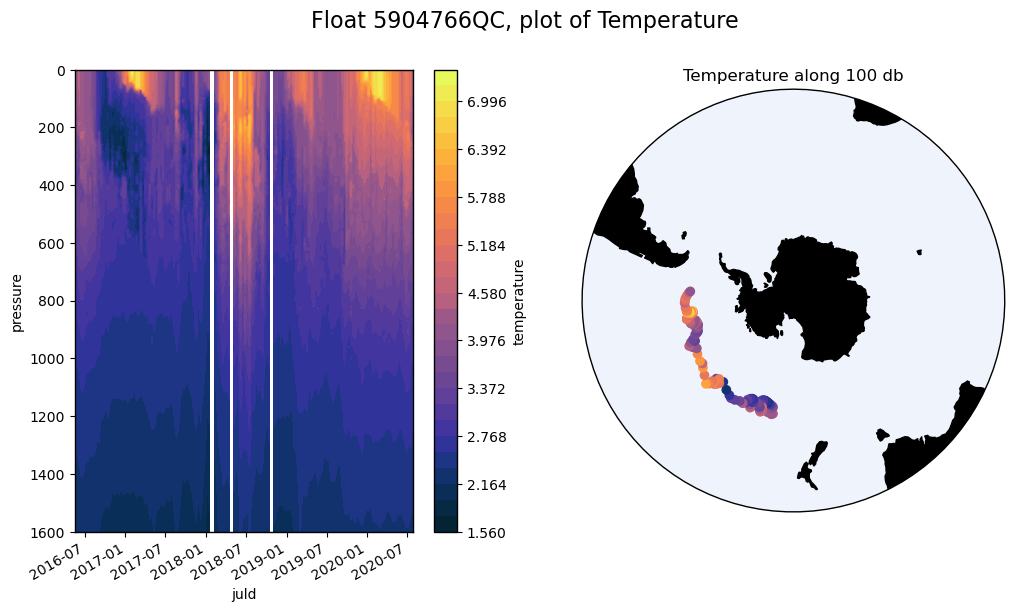

In [210]:
plot_contours_and_float_track(dataset = datasets_SO, floatnum = '5904766QC', variable='temperature', pressure_level = 100)

### List of float numbers

In [117]:
floats_list = datasets_SO.floatnum.values

list_inp = [100, 75, 100, 20, 75, 12, 75, 25] 

set_res = set(floats_list)
floats_list_unique = (list(set_res))

[print(x) for x in floats_list_unique] 

5906442QC
5904181QC
5906206QC
5905075QC
5906492QC
5904682QC
5905106QC
5904475QC
5904984QC
5904767QC
5904657QC
5906032QC
5906316QC
5906313QC
5905101QC
5904855QC
5906217QC
5906306QC
5905109QC
5904685QC
5904679QC
5901492QC
5904671QC
5906490QC
5905105QC
5906489QC
5904467QC
5905369QC
5904673QC
5906002QC
5905994QC
5905984QC
5904182QC
5903593QC
5905368QC
5904659QC
5905370QC
5906487QC
5905998QC
5906304QC
5905103QC
5905639QC
5906004QC
5905373QC
5904843QC
5906207QC
5906213QC
5904396QC
5906250QC
5906226QC
5904980QC
5906310QC
5905985QC
5904179QC
5904675QC
5906225QC
5905069QC
5906208QC
5906214QC
5906488QC
5903612QC
5904468QC
5904660QC
5903718QC
5906006QC
5906209QC
5904188QC
5906224QC
5904765QC
5906035QC
5905133QC
5904683QC
5903717QC
5906033QC
5904662QC
5906496QC
5905635QC
5904670QC
5905996QC
5905108QC
5904672QC
5904658QC
5904184QC
5904842QC
5905072QC
5905993QC
5906221QC
5905379QC
5904477QC
5906215QC
5906228QC
5904693QC
5906007QC
5904678QC
5906220QC
5904763QC
5905367QC
5905380QC
5906246QC
5904845QC


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,